In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [69]:
DATA_PATH = os.path.join("..", "data", "diabetes_prediction_dataset.csv")

In [70]:
df = pd.read_csv(DATA_PATH)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


#### Comprobamos que 'diabetes' tiene muchos valores negativos y muy pocos positivos

In [72]:
# Contar los valores únicos de la columna objetivo 'diabetes'
diabetes_counts = df['diabetes'].value_counts()
diabetes_counts

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [73]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar la variable objetivo y las características
target = "diabetes"
X = df.drop(columns=[target])
y = df[target]

# Identificar variables categóricas y numéricas
categorical_features = ["gender", "smoking_history"]
numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease"]

# Preprocesamiento para variables categóricas (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Preprocesamiento para variables numéricas (escalado estándar)
numeric_transformer = StandardScaler()

# Crear preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Separar en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar preprocesamiento a los datos de entrenamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Verificar dimensiones después del preprocesamiento
X_train_preprocessed.shape, X_test_preprocessed.shape


((80000, 15), (20000, 15))

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir modelos iniciales:
# 1) Regresión Logística
# 2) Random Forest
# 3) XGBoost
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Entrenar y evaluar modelos
results = {}

for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    
    # Evaluar métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Convertir resultados a un DataFrame y mostrar
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.96045,0.858721,0.640000,0.733401
Random Forest,0.97025,0.943775,0.691176,0.797963
XGBoost,0.97125,0.952534,0.696471,0.804621


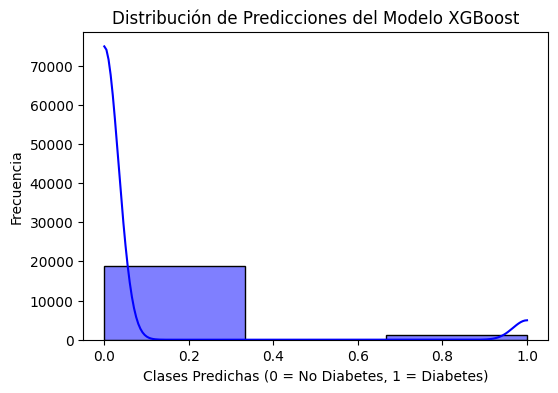

In [ ]:
# Visualizar la distribución de predicciones
plt.figure(figsize=(6, 4))
sns.histplot(y_pred, bins=3, kde=True, color="blue")
plt.xlabel("Clases Predichas (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Predicciones del Modelo")
plt.show()

#### Según el resultado de los modelos en base al Recall vamos a optimizar XGBoost con GridSearchCV o RandomizedSearchCV para mejorar el Recall aún más.

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

from collections import Counter
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]  # Ratio entre clases negativas y positivas

# Definir el modelo XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    random_state=42, 
    scale_pos_weight=scale_pos_weight  # Ajuste de balanceo real
)

# Definir los hiperparámetros a probar:
    # n_estimators: Número de árboles.
    # max_depth: Profundidad máxima de los árboles.
    # learning_rate: Tasa de aprendizaje.
    # subsample: Fracción de muestras a utilizar para entrenar cada árbol.
    # colsample_bytree: Fracción de características (features) para cada árbol.
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=10, cv=3, scoring="recall", 
    n_jobs=-1, random_state=42, verbose=1
)

# Entrenar el modelo
random_search.fit(X_train_preprocessed, y_train)

# Obtener los mejores parámetros y el mejor score (recall)
best_params = random_search.best_params_
best_recall = random_search.best_score_

best_params, best_recall


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

#### Recall muy alto (94.2%): Detecta casi todos los casos positivos, lo cual es ideal en problemas médicos donde los falsos negativos pueden ser críticos.

### Reentrenamos el modelo con GridSearchCV con los mismos hiperparámetros para comprobar su resultado

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Definir el modelo XGBoost con los hiperparámetros óptimos como valores fijos
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42,
    subsample=1.0, n_estimators=100, max_depth=3,
    learning_rate=0.05, colsample_bytree=1.0
)

# Definir un espacio reducido de búsqueda en GridSearchCV
param_grid = {
    "n_estimators": [100],
    "max_depth": [3],
    "learning_rate": [0.05],
    "subsample": [1.0],
    "colsample_bytree": [1.0]
}

# Configurar GridSearchCV con los hiperparámetros ya optimizados
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=3, scoring="recall",
    n_jobs=-1, verbose=1
)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train_preprocessed, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Obtener probabilidades de predicción en el conjunto de prueba
y_pred_probs = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Ajustar el umbral de clasificación a 0.3
threshold = 0.3
y_pred_adjusted = (y_pred_probs >= threshold).astype(int)

# Evaluar métricas con el nuevo umbral
final_results = {
    "Accuracy": accuracy_score(y_test, y_pred_adjusted),
    "Precision": precision_score(y_test, y_pred_adjusted),
    "Recall": recall_score(y_test, y_pred_adjusted),
    "F1-Score": f1_score(y_test, y_pred_adjusted)
}

# Mostrar los resultados finales
results_df = pd.DataFrame([final_results])
results_df


#### Da peor resultado por lo que nos quedamos con el entrenamiento de RandomizedSearchCV

### Creamos un *Pipeline* con preprocesamiento + modelo

In [ ]:
# Pasos a realizar en un Pipeline:
# 1. Imputación de valores faltantes
# 2. Escalado de datos
# 3. Codificación de variables categóricas
# 4. Entrenamiento del modelo

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definir preprocesamiento
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, ["age", "bmi", "blood_glucose_level"]),
    ("cat", categorical_transformer, ["gender", "smoking_history"])
])

# Crear Pipeline con preprocesamiento + modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Aplicar validación cruzada correctamente
scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())


### Resultados de la Validación Cruzada

| **Fold** | **Accuracy** |
|---------|------------|
| **1**   | 94.07% |
| **2**   | 93.98% |
| **3**   | 93.88% |
| **4**   | 93.88% |
| **5**   | 93.89% |

**Accuracy promedio**: **93.94%**


In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir parámetros a optimizar en el Pipeline
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [5, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)


* Los Pipelines mejoran la validación cruzada porque garantizan que el preprocesamiento se realice dentro de cada iteración del entrenamiento, evitando filtraciones de datos y asegurando resultados más realistas y reproducibles.

In [ ]:
# Comprobamos que tiene la misma dimensionalidad las características de train y test
print("Número de características en X_train:", X_train_preprocessed.shape[1])
print("Número de características en X_test:", X_test_preprocessed.shape[1])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener predicciones en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test_preprocessed)

# Generar reporte de clasificación
report = classification_report(y_test, y_pred, output_dict=True)

# Convertir el reporte en un DataFrame para visualización
report_df = pd.DataFrame(report).transpose()

# Mostrar el reporte de clasificación
print(report_df)

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()
